# Create a StationXML for lab
My stations are a bit more transient than a fixed seismic array, so there's a bit of adapting to do here. The AE sensors are mounted in a base plate which has more mount points than I can use in one experiment. I'll define a station at each of the 43 possible mount points. The naming will attempt to follow the __[SEED format](https://ds.iris.edu/ds/nodes/dmc/data/formats/)__, although lab networks may benefit from a slight re-purposing in the future.

__Network code__  
The network code will be `L0` for now (local use only, no FDSN incorporation currently).

__Station codes__  
These are allowed 1 to 5 characters. I'll use four characters numbering the AE stations as `AExx`.

__Location IDs__  
A two character code for separating multiple sensors at the same station - this could be useful when I move sensors around so I'll put a `00` in for now.

__Channel codes__  
Three characters identify the sample rate, instrument type, and orientation. The sample rate options in the SEED manual max out at 5kHz and I usually sample 20MHz for the AE sensors but I'll use the max rate identifier `F`. The AE sensors are approximately high gain seismometers designated by `H` and they are all `Z` components. Every channel is thus `FHZ`.

In [1]:
import obspy
from obspy.core.inventory import Inventory, Network, Station, Channel, Site
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

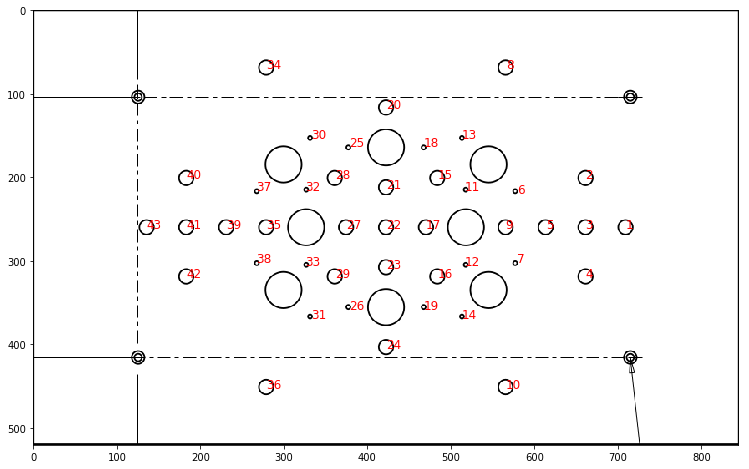

In [14]:
# Load and visualize station array
# Note that all small holes on array.png have since been enlarged to accommodate sensors
# The array was dimensioned in inches but all future references will expect centimeters
x_cm = 2.54 * np.array([20.459, 19.079, 19.079, 19.079, 17.699, 16.7, 16.7, 16.318, 16.318, 16.318, 14.9, 14.9, 14.8, 14.8, 13.958, 13.958, 13.568, 13.5, 13.5, 12.188, 12.188, 12.188, 12.188, 12.188, 10.9, 10.9, 10.808, 10.418, 10.418, 9.6, 9.6, 9.4, 9.4, 8.048, 8.048, 8.048, 7.7, 7.7, 6.668, 5.288, 5.288, 5.288, 3.920])
y_cm = 2.54 * np.array([7.5, 9.2, 7.5, 5.8, 7.5, 8.7, 6.3, 13.02, 7.5, 1.98, 8.8, 6.2, 10.6, 4.4, 9.2, 5.8, 7.5, 10.3, 4.7, 11.64, 8.88, 7.5, 6.12, 3.36, 10.3, 4.7, 7.5, 9.2, 5.8, 10.6, 4.4, 8.8, 6.2, 13.02, 7.5, 1.98, 8.8, 6.3, 7.5, 9.2, 7.5, 5.8, 7.5])
array_img = mpimg.imread('array.png')

fig, ax = plt.subplots(figsize=(15,8))
ax.imshow(array_img)
for i, (x, y) in enumerate(zip(x_cm, y_cm),1):
    xt = (x/(24.375*2.54) * 845) # transform x_cm through inches to pixels on array.png
    yt = ((15*2.54 - y)/(15*2.54)) * 521 # transform y_cm through inches to pixels
    plt.text(xt, yt, str(i), color="red", fontsize=12) # i is 0-indexed, sensors start at 1

## Write the base StationXML file
This only needs to be done once! If GLNNstations.xml already exists, skip ahead to __Add channels__.

This section adds all 43 possible station locations as stations with no channels in the `L0` network.

### Station coordinates
Since my station coordinates are not in the conventional lat, lon, and elevation, I need to __[define custom StationXML tags](https://docs.obspy.org/tutorial/code_snippets/stationxml_custom_tags.html)__. I need to add an `AttribDict` with the custom attributes for (x,y,z) locations. They can be sub-tags of a `local_location` tag. All of this information has to be passed to the `Inventory` object through its `extra` attribute or it will not be included in the StationXML file output.

In [3]:
from obspy.core.util import AttribDict

I had to create the LocalLoc class below, instead of just re-using one `AttribDict` named `local_location`. When I re-used one object, each `sta.extra.local_location` pointed to the same original `local_location` `AttribDict`. As I iteratively changed the location in that object, it changed the one mutable object rather than a new instance of it. Thus I ended up with all of the stations having the last location.

In [53]:
class LocalLoc:
    # Create a local_location template object
    # Fill in local_location.value.<x,y,z>.value for each station
    # Then add the local_location attribute (with the (x,y,z) sub-attributes) by first
    # initializing a Station.extra = AttribDict() then setting
    # Station.extra.local_location = local_location
    
    def __init__(self, x=-1, y=-1):
        ns = 'GLNN' # A namespace is required for the attribute to be included in a StationXML file
        
        # Initialize local_location to contain sub-attributes
        self.local_location = AttribDict()
        self.local_location.namespace = ns
        self.local_location.value = AttribDict()
        
        # Initialize each sub-attribute (x,y,z)
        self.local_location.value.x = AttribDict()
        self.local_location.value.x.namespace = ns
        self.local_location.value.x.attrib = AttribDict({'unit': 'CENTIMETERS'}) # mimicking the way StationXML defines units for e.g. Latitude
        if x>-1:
            self.local_location.value.x.value = x
        
        self.local_location.value.y = AttribDict()
        self.local_location.value.y.namespace = ns
        self.local_location.value.y.attrib = AttribDict({'unit': 'CENTIMETERS'})
        if y>-1:
            self.local_location.value.y.value = y
        
        self.local_location.value.z = AttribDict()
        self.local_location.value.z.namespace = ns
        self.local_location.value.z.attrib = AttribDict({'unit': 'CENTIMETERS'})
        self.local_location.value.z.value = 0 # all default station locations are at z=0

In [55]:
b = LocalLoc(1,12)
b.local_location.value

AttribDict({'x': AttribDict({'namespace': 'GLNN', 'attrib': AttribDict({'unit': 'CENTIMETERS'}), 'value': 1}), 'y': AttribDict({'namespace': 'GLNN', 'attrib': AttribDict({'unit': 'CENTIMETERS'}), 'value': 12}), 'z': AttribDict({'namespace': 'GLNN', 'attrib': AttribDict({'unit': 'CENTIMETERS'}), 'value': 0})})

### Other station components
Each station has the standard set of mandatory attributes and the local_location I just defined. I'll add channels later when I add experiment-specific information. I'll build each station and add it to the `Network` iteratively. I'll put the lab coordinates in for lat and lon, just because that seems more interesting than claiming to be at (0,0).

In [62]:
net = Network(code='L0', description='Glaser Lab Nano Network')

# Iterate over all station locations
for i, (x, y) in enumerate(zip(x_cm, y_cm),1):
    # Create temporary basic station
    sta = Station(
            code='AE%02d' % (i), # format station code as AExx
            latitude=37.874505, # lab location
            longitude=-122.257247, # ...
            elevation=100, # ... (meters)
            creation_date=obspy.UTCDateTime(2018, 1, 1),
            site=Site(name='BP3')) # the baseplate name seems like a reasonable site name
    # Add local_location info, using template local_location object created above
    loc = LocalLoc(x,y)
    sta.extra = AttribDict()
    sta.extra.local_location = loc.local_location
    # Append filled station to the network
    net.stations.append(sta)

In [59]:
# Fill and write the base station inventory
inv = Inventory(networks=[net], source='J. Parker')

In [61]:
inv.write('GLNNstations.xml', format='stationxml',
         nsmap={'GL_ns': 'GLNN'}) # The nsmap makes the xml output cleaner

## Add channels
In this section, we take the base GLNNstations.xml inventory and add channels to the stations used for an experiment.

In [63]:
# define a basic channel
cha = Channel(
    code="FHZ",
    location_code="00",
    latitude=0,
    longitude=0,
    elevation=0,
    depth=0,
    sample_rate=20e6)

In [64]:
# manually input the used station locations, following array map above
stns = {'A1': 27, 'A2': 9,  'A3': 17, 'A4': 22,
        'B1': 38, 'B2': 35, 'B3': 18, 'B4': 11,
        'C1': 21, 'C2': 28, 'C3': 32, 'C4': 41,
        'D1': 16, 'D2': 23, 'D3': 43, 'D4': 33}

In [65]:
# load the base station inventory
inv = obspy.read_inventory('GLNNstations.xml', format='stationxml')
# drop unused stations and sort used
inv[0].stations = [inv[0].stations[i-1] for i in stns.values()]
# add channel to each remaining station
for sta in inv[0].stations:
    sta.channels.append(cha)
inv[0].stations[1]

Station AE09 (BP3)
	Station Code: AE09
	Channel Count: None/None (Selected/Total)
	None - 
	Access: None 
	Latitude: 37.87, Longitude: -122.26, Elevation: 100.0 m
	Available Channels:
		AE09.00.FHZ

In [66]:
# write out the experiment-specific inventory
inv.write('020918_shear/GLNNstations_020918.xml', format='stationxml',
         nsmap={'GL_ns': 'GLNN'})